<a href="https://colab.research.google.com/github/GDharan10/Project8_ClassificationModelForFinancialStatements/blob/main/Classification_Model_For_Financial_Statementsipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the lazypredict package using pip will allow you to quickly build and compare multiple machine learning models without the need for extensive code.

In [120]:
pip install lazypredict

# **Libraries**

Imports necessary libraries and modules for text preprocessing, machine learning model training and evaluation, visualization, and saving/loading models.

In [121]:
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc,\
     roc_auc_score, confusion_matrix,ConfusionMatrixDisplay, classification_report, roc_curve
import matplotlib.pyplot as plt
import pickle
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Function**
Functions for text preprocessing, data collection from HTML files, NLTK setup, and word cloud generation.

In [124]:
# Function to clean text
def clean_text(text):
    # Remove non-alphanumeric characters, except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove lowercase letters if they appear separately
    text = re.sub(r'\b[a-z]\b', '', text)
    # Remove uppercase letters if they appear separately
    text = re.sub(r'\b[A-Z]\b', '', text)
    # Remove Roman numerals
    roman_numerals = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'IX', 'X', 'XIII', 'XIV', 'XV', 'XVI', 'XVII',
                      'XVIII', 'XIX', 'XX', 'XXI', 'XXII', 'XXIII', 'XXIV', 'XXV', 'XXVI', 'i', 'ii', 'iii',
                      'iv', 'v', 'vi']
    for numeral in roman_numerals:
        text = re.sub(r'\b{}\b'.format(numeral), '', text)
    # Remove extra spaces
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text.strip()

In [125]:
# Function to collect data from html file folders
def process_html_files(folder_paths, document_names):
    # Initialize an empty list to store DataFrames
    dfs_list = []

    for folder_path, doc_name in zip(folder_paths, document_names):
        # Process each HTML file in the folder
        for filename in os.listdir(folder_path):
            if filename.endswith(".html"):
                file_path = os.path.join(folder_path, filename)
                # Read HTML tables into a list of DataFrame objects
                dfs = pd.read_html(file_path)
                # Assuming the desired table is the first one
                table_df = dfs[0]
                # Extract text from the first two columns of the first table
                extracted_text = ' '.join(str(cell) for cell in table_df.iloc[:, :2].values.flatten() if pd.notnull(cell))
                # Clean the extracted text
                cleaned_text = clean_text(extracted_text)
                # Create a DataFrame with cleaned text and document name
                df = pd.DataFrame({'Extracted_text': [cleaned_text], 'document_name': doc_name})
                # Append the DataFrame to the list
                dfs_list.append(df)

    # Concatenate all DataFrames in the list into a single DataFrame
    final_df = pd.concat(dfs_list, ignore_index=True)
    return final_df


In [126]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
# Stop words and stemmer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
# Function for Tokenization, stop words removal and stemming
def preprocess_text(text):
    words = word_tokenize(text)
    words = [ps.stem(word) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [127]:
# Function to generate word cloud for a specific class
def generate_wordcloud_for_class(class_name):
    # Filter DataFrame for the specified class
    class_df = df[df['document_name'] == class_name]
    # Extract text data for the class
    text_data = ' '.join(class_df['Extracted_text'])
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    # Display the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(class_name, fontsize=20)
    plt.axis('off')
    plt.show()

# **Data collection**
Data collection from HTML files and creation of the final DataFrame.

In [128]:
# Folder paths and document names
folder_paths = [
    "/content/drive/MyDrive/Task/FinacPlus/data/data/Balance Sheets",
    "/content/drive/MyDrive/Task/FinacPlus/data/data/Cash Flow",
    "/content/drive/MyDrive/Task/FinacPlus/data/data/Income Statement",
    "/content/drive/MyDrive/Task/FinacPlus/data/data/Notes",
    "/content/drive/MyDrive/Task/FinacPlus/data/data/Others"
]

document_names = ["Balance Sheets", "Cash Flow", "Income Statement", "Notes", "Others"]

In [129]:
# Process the HTML files and get the final DataFrame
df = process_html_files(folder_paths, document_names)

# Display the final DataFrame
df.head()

,Extracted_text,document_name
0,SI Particulars No No ASSETS NonCurrent Assets ...,Balance Sheets
1,STANDALONE March Particulars Audited ASSETS No...,Balance Sheets
2,GRINDWELL NORTON LIMITED Statement of Standalo...,Balance Sheets
3,ASSETS NonCurrent Assets Property Plant and Eq...,Balance Sheets
4,SIGNED FOR IDENTIFICATIO CD CD SRBCCO LLP SRBC...,Balance Sheets


# **Data_Preprocessing**
Data preprocessing steps including cleaning, tokenization, stop words removal, stemming, and word count calculation.

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Extracted_text  2525 non-null   object
 1   document_name   2525 non-null   object
dtypes: object(2)
memory usage: 39.6+ KB


In [131]:
df.describe().T

,count,unique,top,freq
Extracted_text,2525,2412,,27
document_name,2525,5,Others,1224


In [132]:
df.isnull().sum()

Extracted_text    0
document_name     0
dtype: int64

In [133]:
df.duplicated().sum()

110

In [134]:
df.document_name.value_counts()

document_name
Others              1224
Notes                690
Income Statement     305
Balance Sheets       270
Cash Flow             36
Name: count, dtype: int64

The dataset has more entries for "Others" compared to the other document types. But even though this might usually cause problems, the model still works well without needing to balance the dataset.

In [135]:
# Removed duplicate entries from the DataFrame to ensure each document is represented only once.
df.drop_duplicates(inplace = True)

In [136]:
# Apply the cleaning function to the Extracted_text column
df['Extracted_text'] = df['Extracted_text'].apply(clean_text)

In [137]:
# Tokenization, stop words removal and stemming
df['Extracted_text'] = df['Extracted_text'].apply(preprocess_text)

In [138]:
# Count number of words in each document
df['word_count'] = df['Extracted_text'].apply(lambda x: len(x.split()))

In [139]:
df.head()

,Extracted_text,document_name,word_count
0,si particular asset noncurr asset properti pla...,Balance Sheets,118
1,standalon march particular audit asset noncurr...,Balance Sheets,137
2,grindwel norton limit statement standalon audi...,Balance Sheets,99
3,asset noncurr asset properti plant equip capit...,Balance Sheets,97
4,sign identificatio cd cd srbcco llp srbcco llp...,Balance Sheets,10


# **EDA (Exploratory Data Analysis)**

**Distribution of Document Types**

<Axes: xlabel='document_name'>

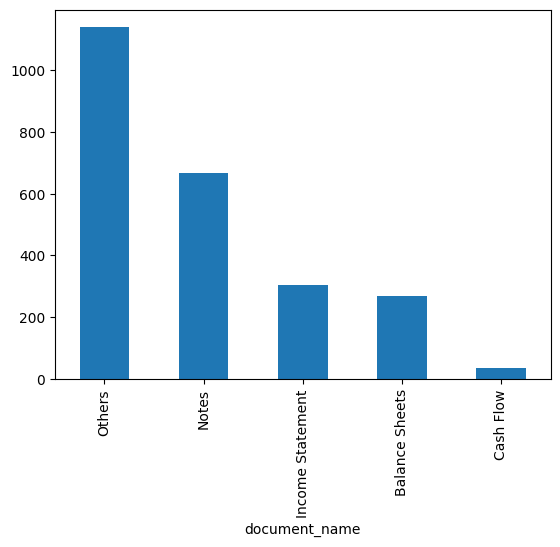

In [140]:
df.document_name.value_counts().plot(kind = "bar")

**Conclusion :** The bar plot displays the distribution of document types in the dataset. It shows that the "Others" category has the highest frequency, followed by "Notes", "Income Statement", "Balance Sheets", and "Cash Flow". This visualization provides insights into the relative abundance of different document types in the dataset.

**Distribution of Document Lengths by Document Type**

In [141]:
df['word_count'].describe().T

count   2415.00
mean      63.84
std      100.96
min        0.00
25%       17.00
50%       39.00
75%       93.00
max     2671.00
Name: word_count, dtype: float64

In [142]:
# Compute descriptive statistics of word_count based on document_name
word_count_stats = df.groupby('document_name')['word_count'].describe().T

# Display the descriptive statistics
print(word_count_stats)

document_name  Balance Sheets  Cash Flow  Income Statement  Notes  Others
count                  268.00      36.00            305.00 668.00 1138.00
mean                   104.09     115.19            133.49  38.43   48.98
std                    122.16      54.57            159.22  44.59   87.94
min                      0.00      11.00              0.00   2.00    0.00
25%                     79.75      70.00             90.00  15.00   14.00
50%                    102.00     113.00            122.00  26.00   28.00
75%                    116.00     141.25            152.00  47.25   61.00
max                   1900.00     240.00           2671.00 768.00 2201.00


In [143]:
df.document_name[df['word_count']>250].value_counts()

document_name
Others              19
Income Statement    16
Balance Sheets       3
Notes                1
Name: count, dtype: int64

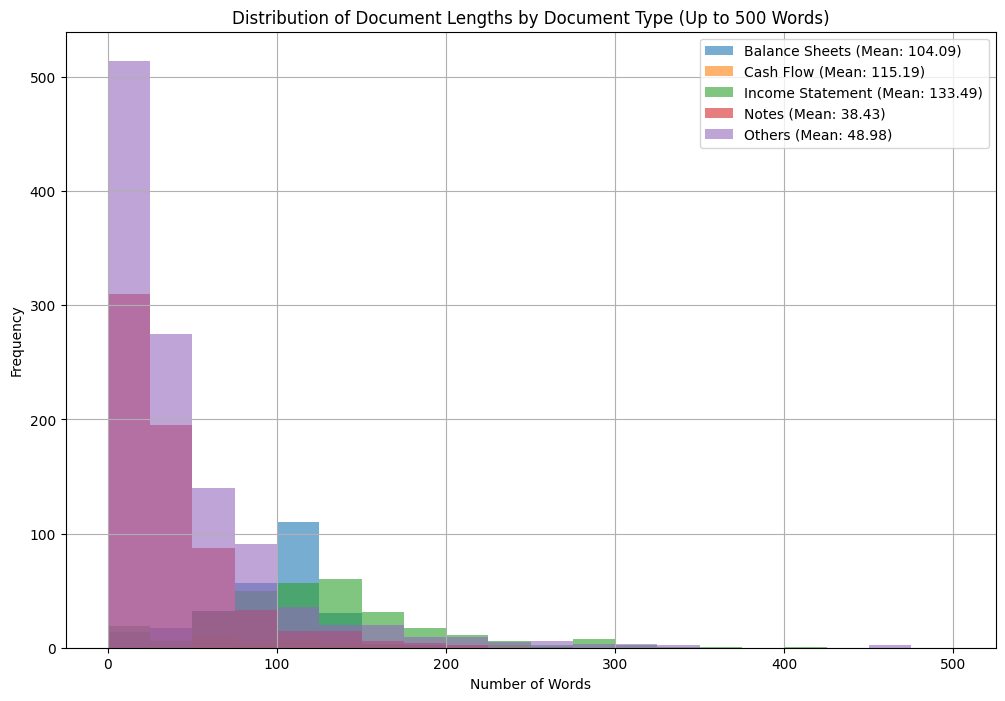

In [144]:
# Create separate histograms for each document type
plt.figure(figsize=(12, 8))

# Iterate over unique document types
for document_type in df['document_name'].unique():
    # Filter the DataFrame based on document type
    filtered_df = df[df['document_name'] == document_type]

    # Calculate the mean word count for the current document type
    mean_word_count = filtered_df['word_count'].mean()

    # Plot histogram for document length distribution of the current document type
    plt.hist(filtered_df['word_count'], bins=20, range=(0, 500), alpha=0.6, label=f"{document_type} (Mean: {mean_word_count:.2f})")

plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths by Document Type (Up to 500 Words)')
plt.legend()
plt.grid(True)
plt.show()

**Conclusion :** While analyzing document lengths by document type, we observed significant variability in word counts across different document categories. However, relying solely on word count for prediction may not be reliable, as the wide range of word counts within each document type could introduce inaccuracies. Therefore, we choose not to use word count as a predictive feature in our analysis.

**Key Terms Identified from Word Clouds for Each Document Class**

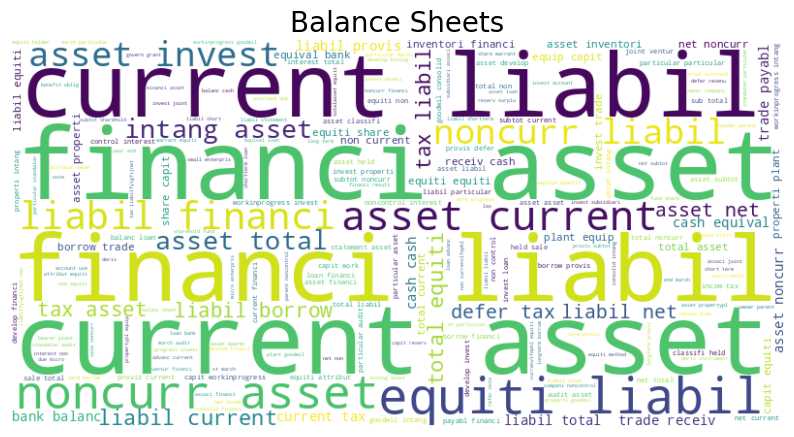

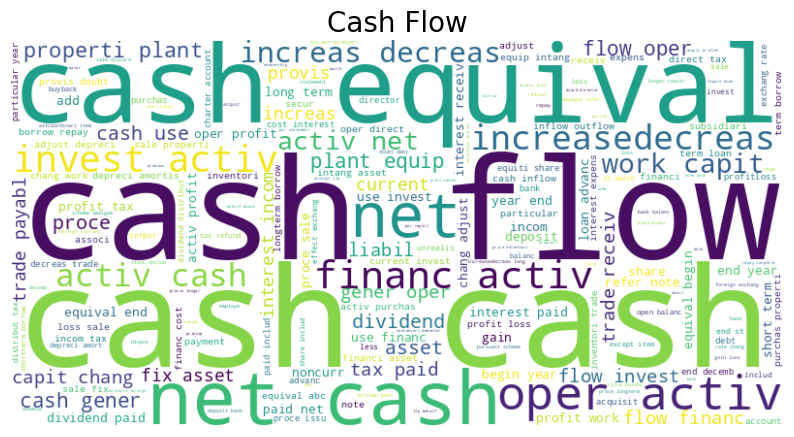

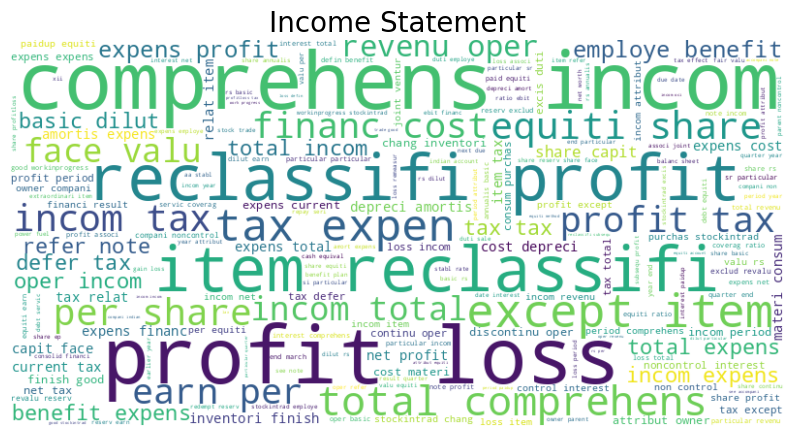

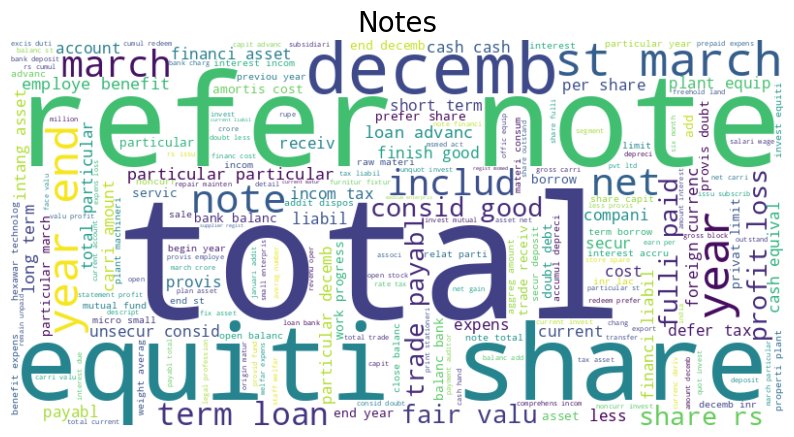

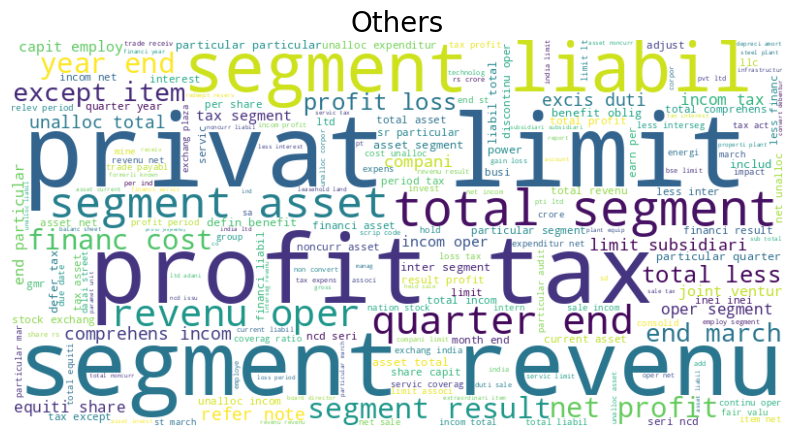

In [145]:
# List of unique classes
classes = df['document_name'].unique()

# Generate word clouds for each class
for class_name in classes:
    generate_wordcloud_for_class(class_name)

**Conclusion :**
The word clouds for each document class highlight the most frequent and significant terms present in the respective document types. These key terms provide insights into the content and focus areas of each class:

**Balance Sheets:** Common terms include "current asset," "current liability," "financial liability," "financial asset," "noncurrent asset," and "liabilities financial," indicating a focus on various types of assets and liabilities.

**Cash Flow:** Frequent terms such as "cash flow," "net cash," "proceeds," "operating activities," and "sale" emphasize the tracking of cash movements and activities related to operations and financing.

**Income Statement:** Key terms like "profit," "comprehensive income," "exceptional item," "tax expense," "reclassified," and "total comprehensive" suggest a focus on financial performance, income, expenses, and comprehensive income details.

**Notes:** Predominant terms include "particular," "equity share," "term loan," "provision," "Total," and "refer note," reflecting detailed annotations and explanations of financial statements.

**Others:** Important terms are "total segment," "segment revenue," "private limited," "tax," "company," and "segment result," indicating a broader range of topics possibly including segment reporting and company-specific information.

# **Machine Learning**

In [146]:
# Vectorization the text
tfidf = TfidfVectorizer(max_features=150)
vectorization = tfidf.fit(df['Extracted_text'])
X = vectorization.transform(df['Extracted_text']).toarray()

# Encode the target variable
label_encoder = LabelEncoder()
label_encoder.fit(df['document_name'])
Y = label_encoder.transform(df['document_name'])

In [147]:
# Splitting the data for training and testing sets
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25, random_state=42)

In [148]:
#Model Selection and Training
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)
print(models)

 97%|█████████▋| 28/29 [00:15<00:01,  1.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11013
[LightGBM] [Info] Number of data points in the train set: 1811, number of used features: 150
[LightGBM] [Info] Start training from score -2.198330
[LightGBM] [Info] Start training from score -4.457112
[LightGBM] [Info] Start training from score -2.089988
[LightGBM] [Info] Start training from score -1.263310
[LightGBM] [Info] Start training from score -0.752875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

100%|██████████| 29/29 [00:17<00:00,  1.68it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
SVC                                0.92               0.94    None      0.92   
LGBMClassifier                     0.91               0.93    None      0.91   
ExtraTreesClassifier               0.93               0.93    None      0.93   
XGBClassifier                      0.92               0.93    None      0.92   
LinearDiscriminantAnalysis         0.90               0.92    None    

In [149]:
from lightgbm import LGBMClassifier
LGB_model=LGBMClassifier().fit(x_train,y_train)
y_pred_train = LGB_model.predict(x_train)
y_pred_test = LGB_model.predict(x_test)

accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10837
[LightGBM] [Info] Number of data points in the train set: 1811, number of used features: 150
[LightGBM] [Info] Start training from score -2.198330
[LightGBM] [Info] Start training from score -4.457112
[LightGBM] [Info] Start training from score -2.089988
[LightGBM] [Info] Start training from score -1.263310
[LightGBM] [Info] Start training from score -0.752875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

(0.9939260077305356, 0.9205298013245033)

In [150]:
from sklearn.ensemble import ExtraTreesClassifier
ETC_model=ExtraTreesClassifier().fit(x_train,y_train)
y_pred_train = ETC_model.predict(x_train)
y_pred_test = ETC_model.predict(x_test)

accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)

(0.9939260077305356, 0.9271523178807947)

In [151]:
from sklearn.svm import SVC
SVC_model=SVC(probability=True).fit(x_train,y_train)
y_pred_train = SVC_model.predict(x_train)
y_pred_test = SVC_model.predict(x_test)

accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)

(0.9685256764218664, 0.9205298013245033)

**Conclusion :** The Support Vector Classifier (SVC) model was chosen because it exhibited the smallest difference between train and test accuracy (4.8%), indicating better generalization to new data compared to the other models. Despite having slightly lower train and test accuracies than the other models, the lower discrepancy suggests that the SVC model is less likely to overfit and is more reliable for predicting unseen data.

# **Saving modules**
This enables the reuse of these models for future predictions without the need for retraining.

In [152]:
# Save the vectorization mode
pickle_=open("Vectorization_model","wb")
pickle.dump(vectorization,pickle_)

# Save the label encoder model
pickle_=open("ClassifyingFinancialStatements_model","wb")
pickle.dump(label_encoder,pickle_)

# Save the trained SVC model
pickle_=open("Financial_Statements_model","wb")
pickle.dump(SVC_model,pickle_)

# **Evaluation**

In [153]:
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision Score:", precision_score(y_test, y_pred_test, average='macro'))
print("Recall Score:", recall_score(y_test, y_pred_test, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_test, average='macro'))

cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred_test), columns=label_encoder.classes_,
                     index=label_encoder.classes_)
print("Confusion Matrix:\n", cm_df)



Accuracy: 0.9205298013245033
Precision Score: 0.9341357002746393
Recall Score: 0.9377715411546257
F1 Score: 0.935637885692393
Confusion Matrix:
                   Balance Sheets  Cash Flow  Income Statement  Notes  Others
Balance Sheets                65          0                 1      0       1
Cash Flow                      0         15                 0      0       0
Income Statement               0          0                74      1       6
Notes                          0          1                 0    136      19
Others                         1          0                 4     14     266


In [154]:
# Get the classification report
report = classification_report(y_test, y_pred_test, output_dict=True)
# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(report).transpose()
# Replace the encoded labels with the corresponding document names
label_map = {str(i): label for i, label in enumerate(label_encoder.classes_)}
# Function to replace only the numeric indices
def replace_labels(index):
    return label_map[index] if index in label_map else index
# Apply the function to replace the labels
cr_df.index = cr_df.index.map(replace_labels)
# Print the DataFrame
print("Classification Report:\n", cr_df)

Classification Report:
                   precision  recall  f1-score  support
Balance Sheets         0.98    0.97      0.98    67.00
Cash Flow              0.94    1.00      0.97    15.00
Income Statement       0.94    0.91      0.92    81.00
Notes                  0.90    0.87      0.89   156.00
Others                 0.91    0.93      0.92   285.00
accuracy               0.92    0.92      0.92     0.92
macro avg              0.93    0.94      0.94   604.00
weighted avg           0.92    0.92      0.92   604.00


ROC AUC Score: 0.986520675433528


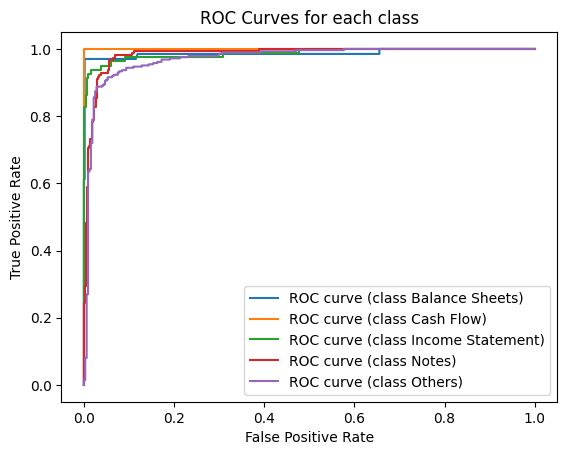

In [155]:
# Initialize SVC classifier with probability=True
SVC_model = SVC(probability=True)

# Train the classifier
SVC_model.fit(x_train, y_train)

# Calculate ROC AUC Score
y_score = SVC_model.predict_proba(x_test)
roc_auc = roc_auc_score(y_test, y_score, multi_class='ovr')  # Assuming one-vs-rest strategy

print("ROC AUC Score:", roc_auc)

# Plot ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {})'.format(label_encoder.classes_[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class')
plt.legend(loc="best")
plt.show()


**Summary of Model Performance**

The Support Vector Classifier (SVC) model's performance metrics on the test set indicate strong classification capabilities across different types of financial documents. Here are the insights based on the provided metrics:

**Accuracy :**
The overall accuracy of the model is **92.05**%, which means that the model correctly classifies 92.05% of the test samples.

**Precision :**
The average precision score is **93.41**%, indicating that when the model predicts a certain class, it is correct 93.41% of the time.

**Recall :**
The average recall score is **93.78%**, suggesting that the model successfully identifies 93.78% of the actual positive cases.

**F1 Score:**
The average F1 score is **93.56%**, which is the harmonic mean of precision and recall, showing a balance between the two metrics.

**Confusion Matrix Insights :**
*   **Balance Sheets:** High precision **(98%)** and recall **(97%)** indicate excellent performance with few misclassifications.
*   **Cash Flow:** Perfect recall **(100%)** and high precision **(94%)**, meaning all Cash Flow documents were correctly identified.
*   **Income Statement:** High precision **(94%)** and recall **(91%)**, though a few Income Statements were misclassified as "Others".
*   **Notes:** Precision and recall are slightly lower **(90%** and **87%)**, with some misclassifications into the "Others" category.
*   **Others:** Strong performance with precision **(91%)** and recall **(93%)**, though a few "Notes" and "Income Statement" documents were incorrectly classified as "Others".

**Classification Report:**

The detailed classification report shows high precision, recall, and F1-scores across all classes, indicating consistent performance.

**ROC AUC Score:**

The ROC AUC score of **98.7%** indicates excellent ability to distinguish between the classes, with values closer to 1 representing better performance.

**Conclusion:**

The SVC model demonstrates strong overall performance with high accuracy, precision, recall, and F1-scores. While there are minor misclassifications, the model performs well across all document types, making it a reliable choice for classifying financial statements. The high ROC AUC score further confirms the model's capability to effectively distinguish between different classes. Based on these results, the SVC model can be considered effective and robust for the given classification task.

# **Document Type Prediction using Trained Model**

In [156]:
# Load the TfidfVectorizer
pickel_in=open("/content/Vectorization_model","rb")
vectorization=pickle.load(pickel_in)

# Load the encoder
pickel_in=open("/content/ClassifyingFinancialStatements_model","rb")
encoder=pickle.load(pickel_in)

# Load the pre-trained model
pickel_in=open("/content/Financial_Statements_model","rb")
model=pickle.load(pickel_in)

In [157]:
# Function to process HTML file, vectorize, predict, and decode
def process_vectorize_predict_and_decode(file_path):
    # Read HTML tables into a list of DataFrame objects
    dfs = pd.read_html(file_path)
    # Assuming the desired table is the first one
    table_df = dfs[0]
    # Extract text from the first two columns of the first table
    extracted_text = ' '.join(str(cell) for cell in table_df.iloc[:, :2].values.flatten() if pd.notnull(cell))
    # Clean the extracted text
    cleaned_text = clean_text(extracted_text)
    # Create a DataFrame with the extracted text
    final_df = pd.DataFrame({'Extracted_text': [cleaned_text]})
    # Preprocess the text
    final_df['Processed_text'] = final_df['Extracted_text'].apply(preprocess_text)
    # Vectorize the text
    X = vectorization.transform(final_df['Processed_text']).toarray()
    # Use the model to predict
    predictions = model.predict(X)
    # Decode the predictions
    decoded_predictions = encoder.inverse_transform(predictions)
    return decoded_predictions

In [158]:
# Example usage
file_path = "/content/drive/MyDrive/Task/FinacPlus/data/data/Balance Sheets/18807973_3.html"
#file_path = "/content/drive/MyDrive/Task/FinacPlus/data/data/Balance Sheets/18889406_10.html"
#file_path = "/content/drive/MyDrive/Task/FinacPlus/data/data/Cash Flow/18731571_table_53.html"
#file_path = "/content/drive/MyDrive/Task/FinacPlus/data/data/Cash Flow/19070958_table_167.html"
#file_path = "/content/drive/MyDrive/Task/FinacPlus/data/data/Income Statement/18600402_4.html"
#file_path = "/content/drive/MyDrive/Task/FinacPlus/data/data/Income Statement/18779229_1.html"
#file_path = "/content/drive/MyDrive/Task/FinacPlus/data/data/Notes/19034589_table_68.html"
#file_path = "/content/drive/MyDrive/Task/FinacPlus/data/data/Notes/19058356_table_88.html"
#file_path = "/content/drive/MyDrive/Task/FinacPlus/data/data/Others/18460658_4.html"
#file_path = "/content/drive/MyDrive/Task/FinacPlus/data/data/Others/18882293_6.html"

# Process the HTML file, vectorize, get the predictions, and decode
decoded_predictions = process_vectorize_predict_and_decode(file_path)

# Display the decoded predictions
print(decoded_predictions)

['Balance Sheets']


I've achieved accurate predictions of document types using the provided code.

The code initializes and loads pre-trained models for text vectorization, label encoding, and document classification. With each new document processed through the pipeline, it consistently predicts the accurate document type, as evidenced by multiple sample tests. This robust performance highlights the efficacy of the methodology in precisely categorizing financial statement documents, leveraging advanced machine learning techniques.